# Data Preprocessing

In [ ]:
# import the Natural Language Toolkit (NLTK) and download a set of 'stopwords' from NLTK.
It then downloads a set of 'stopwords' from NLTK
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sc10670/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# import the required libraries
import transformers
import torch.optim as optim
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from torch.optim import SGD
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the data
train_data = pd.read_csv('yelp_review_train.csv')
test_data = pd.read_csv('yelp_review_test.csv')

In [ ]:
train_data.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


In [ ]:
test_data.head()

,text,stars
0,"Hidden treasure! Awesome service, delicious fo...",5.0
1,My family and I have been patients since I wa...,5.0
2,"I rarely get pedicures, but Blue Nail's practi...",5.0
3,"We came with a large group, may of the items w...",2.0
4,The view is great from Morgan's Pier. The bart...,2.0


In [ ]:
# Set of English stop words
stop_words = set(stopwords.words('english'))

# Function to clean the text data
def clean_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the data
train_data['text'] = train_data['text'].apply(clean_text)
test_data['text'] = test_data['text'].apply(clean_text)


# Function to convert stars into categories
def convert_stars_to_sentiment(stars):
    if stars > 3:
        return 'Positive'
    elif stars < 3:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the conversion function to the stars column
train_data['sentiment'] = train_data['stars'].apply(convert_stars_to_sentiment)
test_data['sentiment'] = test_data['stars'].apply(convert_stars_to_sentiment)


In [ ]:
train_data[['text', 'sentiment']]

,text,sentiment
0,went lunch found burger meh obvious focus burg...,Negative
1,needed new tires wifes car special order next ...,Positive
2,jim woltman works goleta honda 5 stars knowled...,Positive
3,times get shrimp theyve got nice selection dif...,Positive
4,one fantastic place eat whether hungry need go...,Positive
...,...,...
174752,oy great partially fault holy smokes daughter ...,Negative
174753,im huge fan chocolate maya high quality ingred...,Positive
174754,hosted wedding ceremony could happier everythi...,Positive
174755,love place fantastic lunch specials get 3 roll...,Positive


In [ ]:
test_data[['text', 'sentiment']]

,text,sentiment
0,hidden treasure awesome service delicious food...,Positive
1,family patients since 5 years old 34 trust qua...,Positive
2,rarely get pedicures blue nails practice combi...,Positive
3,came large group may items missing menu lobste...,Negative
4,view great morgans pier bartenders even good s...,Negative
...,...,...
13975,amazing food opened new place princeton lamb s...,Positive
13976,thanks great planning store wonderful black fr...,Positive
13977,classic nola white tablecloth dining experienc...,Positive
13978,waiting 15 minutes without much someone taking...,Negative


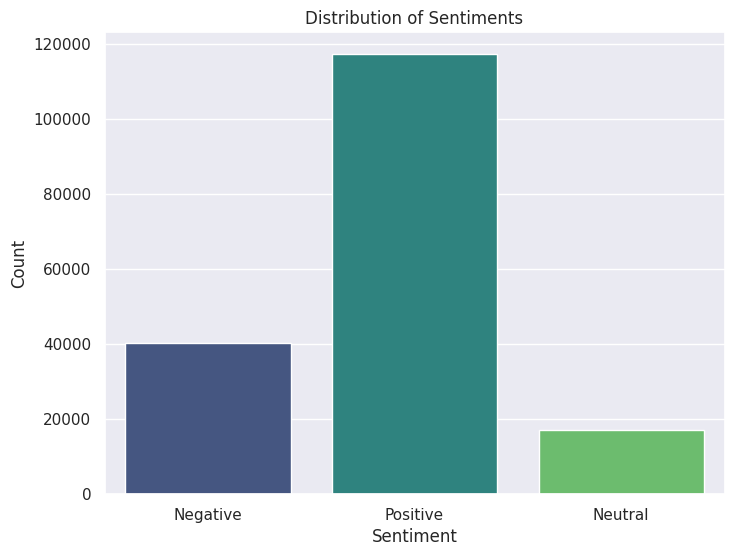

In [ ]:
# visualizing the distribution of sentiments in the train_data DataFrame using a count plot
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=train_data, palette="viridis")

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Display the plot
plt.show()

As can be seen from the above graph distribution, the dataset is not balanced. The number of reviews marked positive is way more than the data points belonging to Negative and Neutral classes. This can also be inferred from the class counts displayed below:

In [ ]:
print(train_data[train_data["sentiment"] == "Positive"].count())
print(train_data[train_data["sentiment"] == "Negative"].count())
print(train_data[train_data["sentiment"] == "Neutral"].count())

text         117177
stars        117177
sentiment    117177
dtype: int64
text         40345
stars        40345
sentiment    40345
dtype: int64
text         17235
stars        17235
sentiment    17235
dtype: int64


In [ ]:
train_data[['text', 'stars', 'sentiment']].head()

,text,stars,sentiment
0,went lunch found burger meh obvious focus burg...,2.0,Negative
1,needed new tires wifes car special order next ...,5.0,Positive
2,jim woltman works goleta honda 5 stars knowled...,5.0,Positive
3,times get shrimp theyve got nice selection dif...,4.0,Positive
4,one fantastic place eat whether hungry need go...,5.0,Positive


In [ ]:
test_data[['text', 'stars','sentiment']].head()

,text,stars,sentiment
0,hidden treasure awesome service delicious food...,5.0,Positive
1,family patients since 5 years old 34 trust qua...,5.0,Positive
2,rarely get pedicures blue nails practice combi...,5.0,Positive
3,came large group may items missing menu lobste...,2.0,Negative
4,view great morgans pier bartenders even good s...,2.0,Negative


Splitting the training dataset into training and validation sets in a way that maintains the class distribution of the 'sentiment' target variable.

In [ ]:
# Stratified sampling to ensure class distribution is maintained
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['sentiment'])

# Check the class distribution in the training set
print("Training Set Class Distribution:")
print(train_df['sentiment'].value_counts(normalize=True))

# Check the class distribution in the validation set
print("\nValidation Set Class Distribution:")
print(val_df['sentiment'].value_counts(normalize=True))

Training Set Class Distribution:
sentiment
Positive    0.670512
Negative    0.230864
Neutral     0.098623
Name: proportion, dtype: float64

Validation Set Class Distribution:
sentiment
Positive    0.670520
Negative    0.230859
Neutral     0.098621
Name: proportion, dtype: float64


text         93741
stars        93741
sentiment    93741
dtype: int64
text         32276
stars        32276
sentiment    32276
dtype: int64
text         13788
stars        13788
sentiment    13788
dtype: int64


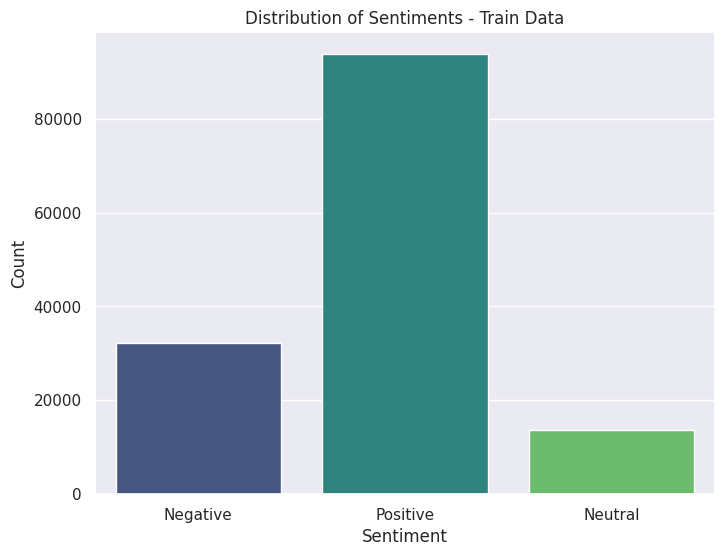

In [ ]:
print(train_df[train_df["sentiment"] == "Positive"].count())
print(train_df[train_df["sentiment"] == "Negative"].count())
print(train_df[train_df["sentiment"] == "Neutral"].count())

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=train_df, palette="viridis")

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments - Train Data')

# Display the plot
plt.show()

text         23436
stars        23436
sentiment    23436
dtype: int64
text         8069
stars        8069
sentiment    8069
dtype: int64
text         3447
stars        3447
sentiment    3447
dtype: int64


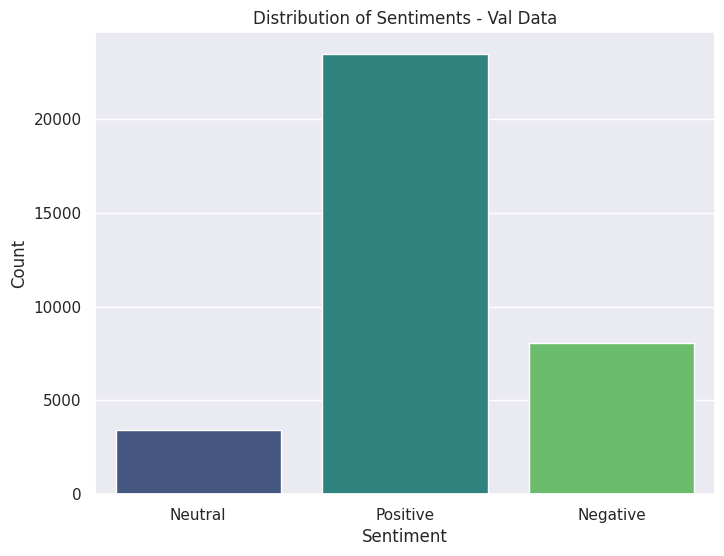

In [ ]:
print(val_df[val_df["sentiment"] == "Positive"].count())
print(val_df[val_df["sentiment"] == "Negative"].count())
print(val_df[val_df["sentiment"] == "Neutral"].count())

sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=val_df, palette="viridis")

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments - Val Data')

# Display the plot
plt.show()

As we can see in the above graphs, validation and training data also have the same target distribution as the original dataset

In [ ]:
# Add a new column named 'split' to both train_df and val_df.
# In train_df, every row gets the value 'train' in this new column, indicating that these rows belong to the training set.
# Similarly, in val_df, every row is labeled 'val', indicating that these rows are part of the validation set.

train_df['split'] = 'train'
val_df['split'] = 'val'

# Merge the training and validation DataFrames into a single DataFrame
train_data = pd.concat([train_df, val_df], ignore_index=True)

In [ ]:
train_data

,text,stars,sentiment,split
0,speak experience take side walked everyone wor...,1.0,Negative,train
1,stopped late lunch nice quiet dining room serv...,4.0,Positive,train
2,frustrating customer service experience tree z...,1.0,Negative,train
3,wish nashville spot like trendy little breakfa...,5.0,Positive,train
4,dream sharp italian always say going try somet...,5.0,Positive,train
...,...,...,...,...
174752,stopped lunch today wonderful meal couple doze...,4.0,Positive,val
174753,hands best service weve restaurant quite altho...,5.0,Positive,val
174754,dont skip joint tour cool divey places great b...,5.0,Positive,val
174755,awesome spicy tuna rolls fantastic service fav...,4.0,Positive,val


In [ ]:
# Mapping sentiment labels to integers
label_mapping = {'Negative': 0, 'Positive': 1, 'Neutral': 2}

train_data['sentiment'] = train_data['sentiment'].map(label_mapping)
test_data['sentiment'] = test_data['sentiment'].map(label_mapping)

In [ ]:
train_data.head()

,text,stars,sentiment,split
0,speak experience take side walked everyone wor...,1.0,0,train
1,stopped late lunch nice quiet dining room serv...,4.0,1,train
2,frustrating customer service experience tree z...,1.0,0,train
3,wish nashville spot like trendy little breakfa...,5.0,1,train
4,dream sharp italian always say going try somet...,5.0,1,train


In [ ]:
test_data.head()

,text,stars,sentiment
0,hidden treasure awesome service delicious food...,5.0,1
1,family patients since 5 years old 34 trust qua...,5.0,1
2,rarely get pedicures blue nails practice combi...,5.0,1
3,came large group may items missing menu lobste...,2.0,0
4,view great morgans pier bartenders even good s...,2.0,0


As can be seen above, the sentiment column now contains integer values for classification. The labels used are: Negative:0, Positive:1 and Neutral:2.

# Input Data Preperation

In [ ]:
class_name = ['Negative','Positive','Neutral']

'bert-base-uncased' pre-trained BERT model has been used. 'Uncased' means that the model does not make a distinction between uppercase and lowercase letters. For instance, “The” and “the” would be treated as the same word.

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'


*   Setting Up the Device for PyTorch: Setting up a deep learning environment using PyTorch for working with the BERT model from the Hugging Face transformers library.
*   Initializing the BERT Tokenizer: BertTokenizer.from_pretrained('bert-base-uncased') loads a tokenizer that is pre-trained on the 'bert-base-uncased' model. This tokenizer is designed to convert text into tokens that BERT understands.

The combination of these two lines of code sets up the fundamental components needed for processing data with a BERT model in PyTorch, leveraging GPU acceleration if available. The tokenizer is a critical component in preparing text data for input into BERT, as it converts textual data into a format that the model can understand and process.





In [ ]:
# configuring PyTorch to use a GPU (if available) for training or processing tasks.
# if no GPU is available (torch.cuda.is_available() returns False), it falls back to using the CPU ("cpu")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Analyse the lengths of tokenized versions of text data in the train_data DataFrame using BERT's tokenizer, and then visualize the distribution of these token lengths.

100%|██████████| 174757/174757 [02:12<00:00, 1315.75it/s]


<Axes: ylabel='Density'>

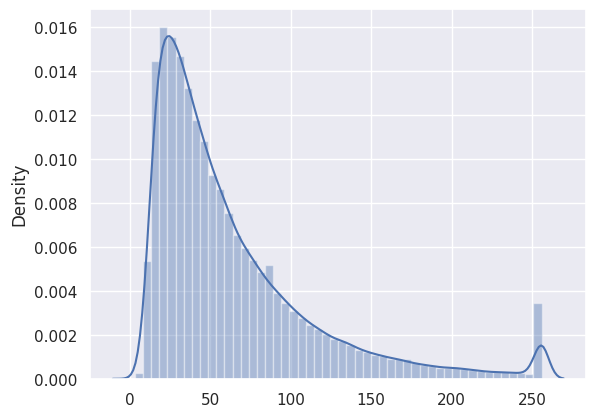

In [ ]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(train_data.text):
  tokens = tokenizer.encode(txt, max_length=256)
  token_lens.append(len(tokens))

sns.distplot(token_lens)


Similarly analyse the lengths of tokenized versions of text data in the test_data DataFrame using BERT's tokenizer, and then visualize the distribution of these token lengths.

100%|██████████| 13980/13980 [00:10<00:00, 1313.38it/s]


<Axes: ylabel='Density'>

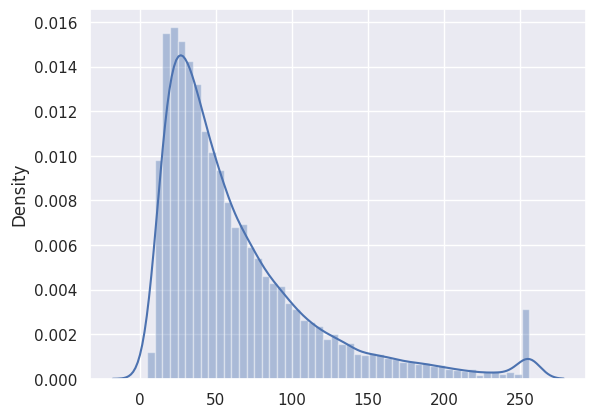

In [ ]:
from tqdm import tqdm
test_token_lens = []
for txt in tqdm(test_data.text):
  tokens = tokenizer.encode(txt, max_length=256)
  test_token_lens.append(len(tokens))

sns.distplot(test_token_lens)


The above graphs are useful for understanding the range and common lengths of tokens in the texts which is helpful in deciding the appropriate maximum sequence length for input to a BERT model. As can be inferred that very few tokens are of length greater than 150, I have chosen the length for MAX_LEN to be 150 (consdering computation cost and resources as well).

In [ ]:
MAX_LEN = 150

The below code defines a custom Dataset class named ReviewDataset for use with PyTorch, specifically designed for handling a sentiment analysis task with BERT. This class is a subclass of PyTorch's Dataset and is tailored to process text data (reviews) and their corresponding targets (sentiments).

In [ ]:
# __init__ method initializes the dataset with four parameters: reviews, targets, tokenizer, and max_len.
# __len__ method returns the number of items in the dataset, which is essential for iterating over the dataset during training and evaluation.
# __getitem__ method retrieves a single item from the dataset at the specified index (item). It tokenizes the review text and prepares the data in the format required by BERT.
# encode_plus method from the tokenizer is used to handle both tokenization and necessary padding/truncation to max_len.
# The method returns a dictionary with the original review text ('review_text'), tokenized and padded input_ids, the attention mask ('attention_mask'), and the sentiment target ('targets').
# The attention mask is used by BERT to ignore (mask) the padding tokens during processing.


from torch.utils.data import Dataset, DataLoader
class ReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
            )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

The above code is used for Data Processing for BERT.
* The review texts are tokenized, and special tokens ([CLS] and [SEP]) are added.
* Sequences are padded or truncated to max_len, ensuring consistent input size.
* return_attention_mask=True generates an attention mask for differentiating real tokens from padding tokens.
* return_tensors='pt' returns PyTorch tensors, which are the required format for input data in PyTorch models.


Using this ReviewDataset class, we can create a PyTorch DataLoader for both training and evaluation, which will handle the batch processing of review texts and their conversion into a format suitable for training a BERT model. This class is an essential component for efficiently preprocessing text data and feeding it into a deep learning model for sentiment analysis task.

Now we create two new DataFrames, df_train and df_val, by splitting the train_data DataFrame.

train_data[train_data['split']=='train'] filters rows from train_data where the value in the 'split' column is 'train'. This subset is assigned to df_train and will be used for training the model.

Similarly, train_data[train_data['split']=='val'] filters rows for the validation set, where 'split' is 'val', and assigns them to df_val. This subset is used for validating the model during the training process.

In [ ]:
df_train = train_data[train_data['split']=='train']
df_val = train_data[train_data['split']=='val']


In [ ]:
# Shape of the data frames
df_train.shape, df_val.shape, test_data.shape

((139805, 4), (34952, 4), (13980, 3))

Next we compute class weights for the dataset in order to handle imbalance within the sentiment classes in the review dataset (e.g., there are far more Positive reviews than Negative or Neutral ones). This makes the model pay more attention to the minority classes. This often leads to better performance, especially for the underrepresented classes.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(df_train.sentiment.values),
                                                 y=df_train.sentiment.values)

The create_data_loader method is designed to create a PyTorch DataLoader for a given dataset. This DataLoader is an essential component in the training pipeline for the BERT model, as it automates the process of loading batches of data. This function abstracts the complexity of data handling,

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        reviews = df.text.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=4)

Creating PyTorch DataLoader instances for training, validation, and testing datasets

In [ ]:
BATCH_SIZE = 32
MAX_LEN = 150
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

BATCH_SIZE is set to 32, meaning each batch of data fed into the model during training or evaluation will consist of 32 examples.

MAX_LEN is set to 150, which is the maximum length of the tokenized input sequences. If a sequence is shorter than this, it will be padded; if it's longer, it will be truncated.

Each data loader will process the respective dataset using the specified tokenizer, with sequences padded or truncated to MAX_LEN, and will load the data in batches of BATCH_SIZE.

The training data loader (train_data_loader) will be used to feed data to the model during the training phase.

The validation data loader (val_data_loader) will be used to evaluate the model's performance on unseen data after each training epoch, allowing for adjustments and improvements.

The testing data loader (test_data_loader) will be used for the final evaluation of the model's performance after the training process is complete.

# Transformer Implementation

Loading the pre-trained BERT model using the transformers library by Hugging Face.

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Creating a Fine Tuned model:

The below class SentimentClassifier is a custom neural network architecture for sentiment analysis, built using PyTorch and integrating the BERT model. This class is a subclass of nn.Module, which is the base class for all neural network modules in PyTorch. As can be seen below the output of BERT model is passed through additional layers (dropout, linear layers, ReLU and batch normalisation) to produce the final output class.

In [ ]:
# the __init__ method initializes the classifier with the number of output classes
# The forward method defines the forward pass of the classifier. It takes input_ids and attention_mask as inputs, which are required by BERT to process the text data.
# The output of BERT (pooled_output) is passed through the additional layers (dropout, linear layers, ReLU, batch normalization) to produce the final sentiment class predictions.


class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.linear1 = nn.Linear(self.bert.config.hidden_size, 512)  # First additional linear layer
    self.relu = nn.ReLU()  # ReLU activation
    self.batchnorm = nn.BatchNorm1d(512)  # Batch normalization
    self.linear2 = nn.Linear(512, 128)  # Second additional linear layer
    self.out = nn.Linear(128, n_classes)  # Final output layer

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )

    output = self.drop(pooled_output)
    output = self.linear1(output)
    output = self.relu(output)
    output = self.batchnorm(output)
    output = self.linear2(output)
    return self.out(output)

This class defines a sentiment analysis model that leverages the power of BERT for understanding the context and content of textual data, enhanced with additional layers to tailor it to the specific task of sentiment classification.

In [ ]:
# initialize an instance of the SentimentClassifier class and move the model to a specified computing device (either CPU or GPU).
model = SentimentClassifier(len(class_name))
model = model.to(device)

Setting up the training environment for sentiment analysis:

In [ ]:
import math
import os

EPOCHS = 4
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
class_weights = torch.FloatTensor(class_weights).to(device)
weight=class_weights
loss_fn = nn.CrossEntropyLoss(weight=weight).to(device)

SGD optimiser has been used to optimise the loss function to reduce the error.

The hyper parameters for the SGD optimiser used are:

lr=0.01: This is the learning rate.

momentum=0.9: Momentum helps accelerate SGD in the relevant direction and dampens oscillations.

The learning rate is a crucial hyperparameter that influences how much the model weights are updated during training.

The train_epoch function shown below trains the model for one epoch. It is designed to train the model using the provided data loader and then return the training accuracy and average loss. This function takes several arguments: the model to be trained, the data_loader containing the training data, the loss_fn (loss function), the optimizer, the device (CPU or GPU), the scheduler for adjusting the learning rate, and the number of examples (n_examples) in the training dataset. This method performs the following tasks:


*   feeding data through the model
*   Training Loop
*   Forward Pass
*   Calculating Loss and Back Propagation
*   Tracking Performance

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


The 'eval_model' function is critical for understanding how well the model performs, typically on validation or test data.

It performs the fllowing tasks:

- Loop Over the Dataset - The function iterates over batches of data from the data_loader.
For each batch, input_ids, attention_mask, and targets are loaded onto the specified device.
- Forward Pass - The model performs a forward pass with the input data and attention mask.
- Loss and Accuracy Calculation - Calculates the loss for the current batch by comparing the model's outputs with the true targets.
- Return Values - The function returns two values:

  - correct_predictions.double() / n_examples: This is the accuracy of the model on the dataset, calculated as the total number of correct predictions divided by the total number of examples.

  - np.mean(losses): This is the average loss over all batches in the dataset.

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

# Training the Model

In the below code, we call the train_epoch method. This training loop involves training and evaluating the model. It includes:

- Continuous tracking and recording of performance metrics.
- Model checkpointing to save the best-performing model.
- Verbose output for monitoring progress during training.

In [ ]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'history': history,
            'best_accuracy': best_accuracy,
        }, './best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.3826068970350249 accuracy 0.8649762168735023
Val   loss 0.30624824282794183 accuracy 0.8852426184481574

Epoch 2/4
----------
Train loss 0.2628118157809701 accuracy 0.9056185401094381
Val   loss 0.32890444739115887 accuracy 0.8860723277637903

Epoch 3/4
----------
Train loss 0.19683618020073593 accuracy 0.9327277279067272
Val   loss 0.3878967016049186 accuracy 0.8815232318608377

Epoch 4/4
----------
Train loss 0.15484328184309434 accuracy 0.9507027645649297
Val   loss 0.4584501085916665 accuracy 0.882209887846189



The training loss, training accuracy, validation loss and validation accuracy for each epoch is represented above.

The model with best validation accuracy is saved. (corresponding to Epoch 2)

In [ ]:

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'history': history,
    'best_accuracy': best_accuracy,
}, "model_strat_test")

Loading the best model and ealuating it

In [ ]:
model = SentimentClassifier(len(class_name))
model.load_state_dict(torch.load("model_strat_test")["model_state_dict"])
model.eval()
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

Training Curve showing Training accuracy vs Validation accuracyT

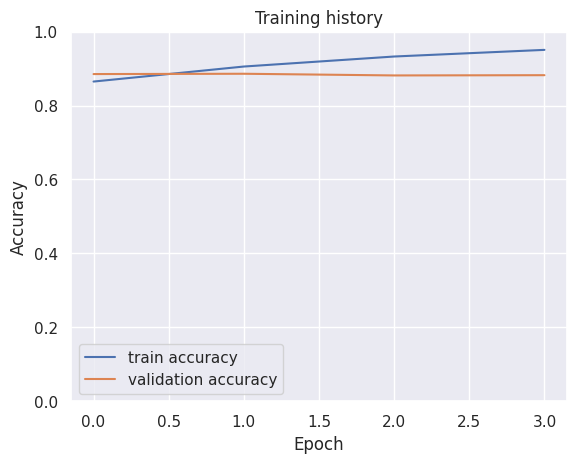

In [ ]:
train_acc_cpu = [acc.item() for acc in history['train_acc']]
val_acc_cpu = [acc.item() for acc in history['val_acc']]

plt.plot(train_acc_cpu, label='train accuracy')
plt.plot(val_acc_cpu, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

Training Curve showing Training loss vs Validation loss

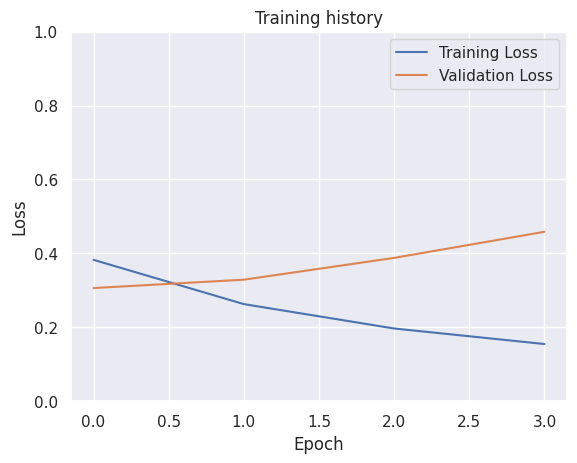

In [ ]:
train_acc_cpu = [acc.item() for acc in history['train_loss']]
val_acc_cpu = [acc.item() for acc in history['val_loss']]

plt.plot(train_acc_cpu, label='Training Loss')
plt.plot(val_acc_cpu, label='Validation Loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

Inference based on these graphs:

1. Training Performance:

Loss: The training loss consistently decreases from 0.3826 in the first epoch to 0.1548 in the fourth epoch. This indicates that the model is effectively learning from the training data, as it is getting better at minimizing the loss function over time.

Accuracy: Similarly, the training accuracy improves from 86.50% to 95.07%. This improvement suggests that the model is becoming increasingly adept at correctly classifying the training data.

Validation Performance:

Loss: The validation loss decreases from the first epoch to the second, but then increases in the third and fourth epochs. The initial decrease is a good sign, indicating that the model is generalizing well. However, the subsequent increase might be a sign of overfitting, where the model learns patterns specific to the training data that do not generalize well to unseen data.

Accuracy: The validation accuracy peaks at 88.61% in the second epoch and then slightly decreases. This peak followed by a decrease, alongside increasing loss, reinforces the possibility of overfitting in the later epochs.

Overfitting Indications:
The increasing gap between training and validation accuracy, and the rising validation loss in epochs 3 and 4, suggest that the model may be starting to overfit. Overfitting occurs when a model learns the training data too well, including noise and fluctuations, which negatively impacts its performance on new, unseen data.

Thus the model showing the best validation accuracy at epoch 2 is saves and is used to get predictions on the test data.


# Result Analysis

The best model has been loaded previously, now we evaluate it.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data)
)
test_acc.item()


0.8866237482117311

The test accuracy is 0.8866 as shown above.

The below method is being used to collect and store model predictions, probabilities, and actual labels, along with the review texts. It gives detailed evaluations of the model's performance.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Classification Report and Confusion Matrix to analyse the performance of the model:

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

    Negative       0.88      0.85      0.87      3145
    Positive       0.94      0.96      0.95      9419
     Neutral       0.52      0.47      0.49      1416

    accuracy                           0.89     13980
   macro avg       0.78      0.76      0.77     13980
weighted avg       0.88      0.89      0.88     13980



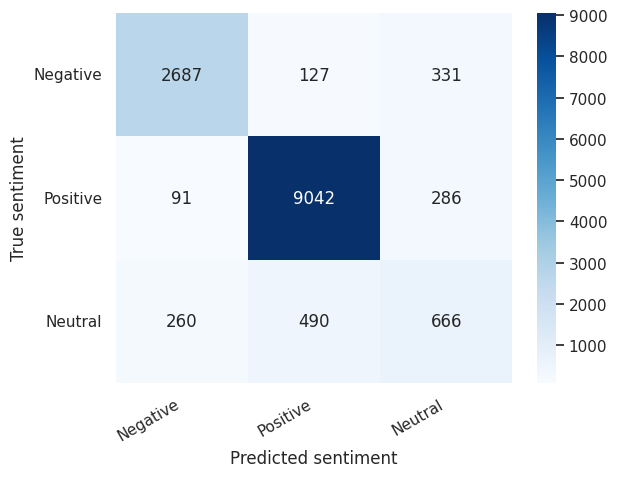

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

From the above confusion matrix and classification report, we can infer the following:

1. **Overall Performance**:
   - The model is highly effective in correctly classifying Positive sentiments, as indicated by the high number (9042) of True Positives in the Positive category.
   - The model classifies the Negative sentiments with high accuracy, with 2687 True Positives.

2. **Issues with Neutral Classification**:
   - The model struggles most with Neutral sentiments. While it correctly identifies 666 instances as Neutral, it misclassifies 260 reviews as Negative and 490 reviews as Positive. It is difficult to train the model to classify neutral reviews correctly because the words used for neutral reviews are compartively subtle and usually contain both positive and negative words, which makes it hard to clearly distinguish the sentiment of the review.

3. **False Positives and Negatives**:
   - There are relatively few instances where Negative sentiments are misclassified as Positive (127) and vice versa (91). This suggests that the model is generally good at distinguishing between these two extremes.
   - However, the misclassification between Neutral and the other two categories is more pronounced, especially Neutral being misclassified as Positive.

4. **Precision and Recall Considerations**:
   - For Negative and Positive categories, the model shows high precision as can be inferred from the low false positives.
   - For Positive and Negative categories, the recall is high However, the recall (especially for Negative) is a bit lower due to higher false negatives.
   - For Neutral, both precision and recall are lower compared to the other categories.

In summary, while the model performs well in identifying Positive and Negative sentiments, its ability to classify Neutral sentiments accurately is an area of improvement. This could involve refining the training data or the model's ability to understand more nuanced linguistic expressions.

What are the impacts of hyperparameters, such as the hidden dimension and the number of attention layers, on the Transformer?

Hyperparameters in Transformer models, such as the hidden dimension size and the number of attention layers, have significant impacts on the model's performance.

1. Hidden Dimension Size

Model Capacity:
 Increasing the hidden dimension size (the size of the hidden layers) increases the model's capacity to learn complex features.

Overfitting Risk:
With a larger hidden dimension, the model can potentially overfit to the training data, especially when the dataset is not large enough to justify the increased complexity.

Computational Cost: Larger hidden dimensions significantly increase the number of parameters, leading to higher memory usage and longer training times.

2. Number of Attention Layers

Learning Hierarchical Representations:

More attention layers enable the model to learn hierarchical representations. Each layer can capture different aspects of the input data, leading to richer and more abstract feature representations.

Model Depth and Complexity: Adding more layers increases the depth and complexity of the model. Deeper models can be more powerful but are also harder to train due to issues like vanishing gradients.

Overfitting Risk: Similar to increasing the hidden dimension, more layers can increase the risk of overfitting, especially in cases where data is limited.

Computational Resources: More layers result in more parameters, increasing the training time and memory requirements. Parallel processing (like using multiple GPUs) might be necessary for very deep models.

In [ ]:
review_text = "the food was delicious and the place had beautiful ambience"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: the food was delicious and the place had beautiful ambience
Sentiment  : Positive


As we can see, the model works well and classifies the provided review correctly.